# EDS6340 - Introduction to Data Science - Project Phase 2

## Group 10
Achanta, Sai Praneeth | 2302324 <br>
Montanez, Derek N | 1920577 <br>
Sai Kiran Anugam | 2312298 <br>
Sandeep Kokkula | 2102358 <br>
Seelam, Gayathri | 2297215 <br>
Venkata Kaushik Belusonti | 2284811

## Step 4: Usethe best model from step 1 and step 3 and perform another variable selection using a Bi-directional elimination as a wrapper method

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import statsmodels.api as sm


### Review the cleaned dataset from Phase 2

In [5]:
# Read the clean dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/Secondary_Mushroom_Dataset/Group_10_Data_Cleaning.csv")
df = df.drop(['Unnamed: 0'], axis = 1)
# Display the first few tuples of the dataset
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,1,2.340396,6,2,6,0,2,10,2.409448,0.675929,11,1,2,0,3
1,1,2.340396,6,2,6,0,2,10,2.409448,0.812813,11,1,2,0,2
2,1,2.053072,6,2,6,0,2,10,2.409448,0.756815,11,1,2,0,3
3,1,2.079925,2,3,1,0,2,10,2.409448,0.537799,11,1,5,0,3
4,1,2.206132,6,3,6,0,2,10,2.409448,0.689617,11,1,5,0,3


In [6]:
# Display the column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60923 entries, 0 to 60922
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 60923 non-null  int64  
 1   cap-diameter          60923 non-null  float64
 2   cap-shape             60923 non-null  int64  
 3   cap-surface           60923 non-null  int64  
 4   cap-color             60923 non-null  int64  
 5   does-bruise-or-bleed  60923 non-null  int64  
 6   gill-attachment       60923 non-null  int64  
 7   gill-color            60923 non-null  int64  
 8   stem-height           60923 non-null  float64
 9   stem-width            60923 non-null  float64
 10  stem-color            60923 non-null  int64  
 11  has-ring              60923 non-null  int64  
 12  ring-type             60923 non-null  int64  
 13  habitat               60923 non-null  int64  
 14  season                60923 non-null  int64  
dtypes: float64(3), int6

#### Split the features into predicted features and target feature

In [7]:
# Split the features to predicted (X) and target (y)
X = df.drop('class', axis=1)
y = df['class']

#### Dataset splitted to Train (80%) and Test (20%)

In [8]:
# Split the dataset into train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Read the data from pickles
X_train = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/ipynb_Files/dummy_Xtrain.pkl")
X_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/ipynb_Files/dummy_Xtest.pkl")
y_train = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/ipynb_Files/dummy_ytrain.pkl")
y_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/ipynb_Files/dummy_ytest.pkl")
X_train_selected = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/ipynb_Files/dummy_Xtrain_selected.pkl")
X_test_selected = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/ipynb_Files/dummy_Xtest_selected.pkl")

### Define functions to estimate the performance metrics


In [9]:
# Function for perfromance metric of data
def Perf_Metric(Actual_Ouput, Prediction_Output):
  # Actual_Ouput is the actual output of training data taken from the dataset
  # TrainData_Prediction is the predicted output from the model for the training data
  Accuracy = round(accuracy_score(Actual_Ouput, Prediction_Output),3)
  F1Score = round(f1_score(Actual_Ouput, Prediction_Output),3)
  Precision = round(precision_score(Actual_Ouput, Prediction_Output),3)
  Recall = round(recall_score(Actual_Ouput, Prediction_Output),3)
  return [Accuracy, F1Score, Precision, Recall]

# Step 2 - Feature Selection using Bidirectional Method

1. Random Forest machine learning model is selected
2. 95% significance level is taken into account for backward feature elimination

In [10]:
# Funtion to select the best features using Bidirectional Elimination Wrapper Method
def stepwise_selection(mushroom_data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = mushroom_data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(mushroom_data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(mushroom_data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features, p_values

In [11]:
# Extract the best features
best_features, pvals = stepwise_selection(X,y)

<ipython-input-10-1c1707730ed0>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-10-1c1707730ed0>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-10-1c1707730ed0>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-10-1c1707730ed0>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-10-1c

In [12]:
# Display best features
best_features


['cap-diameter',
 'ring-type',
 'cap-shape',
 'stem-color',
 'habitat',
 'season',
 'cap-color',
 'stem-width',
 'cap-surface',
 'has-ring',
 'does-bruise-or-bleed',
 'stem-height',
 'gill-color']

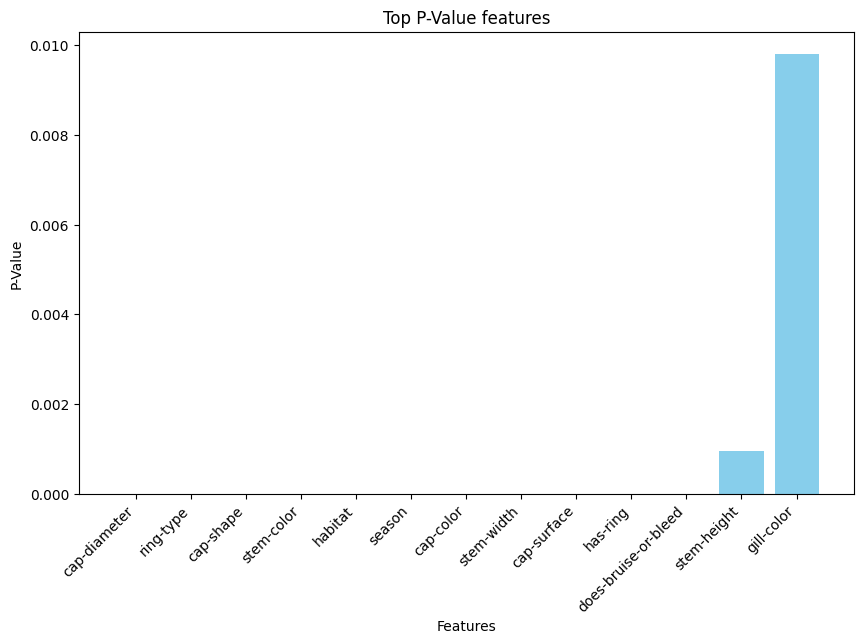

In [13]:
# Visualization of top p -values
plt.figure(figsize=(10, 6))
plt.bar(best_features, pvals, color='skyblue')
plt.title(f'Top P-Value features')
plt.xlabel('Features')
plt.ylabel('P-Value')
#plt.ylim(.00001, .01)
plt.xticks(rotation=45, ha='right')
plt.show()

In [14]:
pvals

cap-diameter             4.137299e-40
ring-type                5.952384e-95
cap-shape               1.655857e-151
stem-color              2.385699e-105
habitat                  5.105413e-86
season                   3.046548e-50
cap-color                1.653644e-54
stem-width               2.233588e-40
cap-surface              2.783157e-38
has-ring                 4.532416e-25
does-bruise-or-bleed     4.833682e-15
stem-height              9.618921e-04
gill-color               9.802804e-03
dtype: float64

1. 13 out of 15 features are shortlisted from Bidirectional Elimination method

In [15]:
# Get the train and test data with best features
X_train_step4 = X_train[best_features]
X_test_step4 = X_test[best_features]


# Random Forest

In [16]:
# Fit the model from training data using Random Forest
model = RandomForestClassifier()
rf = model.fit(X_train_step4, y_train)

In [17]:
# Model fit with training data
y_train_predict = rf.predict(X_train_step4)
# Make predictions on the test data
y_pred = rf.predict(X_test_step4)

In [18]:
# Evaluate performance metric for training and testing data
Train_PM = Perf_Metric(y_train,y_train_predict)
Test_PM = Perf_Metric(y_test,y_pred)

RF_Step5_Train_PM = Train_PM
RF_Step5_Test_PM = Test_PM

In [19]:
# Create a table comparing the preformance on training and test data
models = pd.DataFrame({
    #'Model': ['RF'],
    'Dataset': ["Train","Test"],
    'Accuracy Score': [Train_PM[0], Test_PM[0]],
    'F1 Score': [Train_PM[1], Test_PM[1]],
    'Precision': [Train_PM[2], Test_PM[2]],
    'Recall': [Train_PM[3], Test_PM[3]],
})
models

,Dataset,Accuracy Score,F1 Score,Precision,Recall
0,Train,1.000,1.000,1.000,1.000
1,Test,0.998,0.998,0.998,0.998


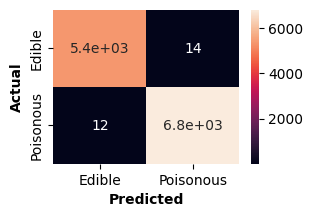

In [20]:
# Plot Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(3, 2))
sns.heatmap(cm,
           annot=True,
           annot_kws={"size":10},
           xticklabels=['Edible', 'Poisonous'],
           yticklabels=['Edible', 'Poisonous'],)
plt.xlabel('Predicted',fontweight='bold')
plt.ylabel('Actual',fontweight='bold');

# Random Forest without Bidirectional Feature Elimation

In [21]:
# Fit the model from training data using Random Forest
model = RandomForestClassifier()
rf = model.fit(X_train, y_train)

In [22]:
# Model fit with training data
y_train_predict = rf.predict(X_train)
# Make predictions on the test data
y_pred = rf.predict(X_test)

In [23]:
# Evaluate performance metric for training and testing data
Train_PM = Perf_Metric(y_train,y_train_predict)
Test_PM = Perf_Metric(y_test,y_pred)

RF_Train_PM = Train_PM
RF_Test_PM = Test_PM

In [24]:
# Create a table comparing the preformance on training and test data
models = pd.DataFrame({
    #'Model': ['RF'],
    'Dataset': ["Train","Test"],
    'Accuracy Score': [Train_PM[0], Test_PM[0]],
    'F1 Score': [Train_PM[1], Test_PM[1]],
    'Precision': [Train_PM[2], Test_PM[2]],
    'Recall': [Train_PM[3], Test_PM[3]],
})
models

,Dataset,Accuracy Score,F1 Score,Precision,Recall
0,Train,1.000,1.000,1.000,1.000
1,Test,0.999,0.999,0.999,0.999


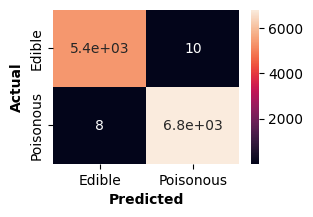

In [25]:
# Plot Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(3, 2))
sns.heatmap(cm,
           annot=True,
           annot_kws={"size":10},
           xticklabels=['Edible', 'Poisonous'],
           yticklabels=['Edible', 'Poisonous'],)
plt.xlabel('Predicted',fontweight='bold')
plt.ylabel('Actual',fontweight='bold');

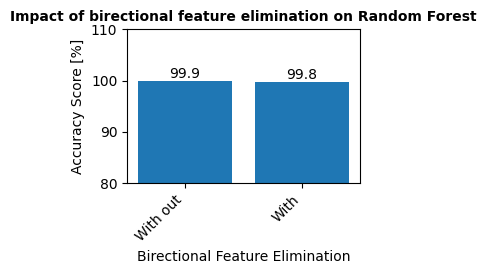

In [26]:
# Impact of Bidirectional elimination on Random Forest
hyperpar_names = ["With out","With"]
hyperpar_acc = [round(RF_Test_PM[0]*100,3), round(RF_Step5_Test_PM[0]*100,3)]
#aman_uni = pd.DataFrame(review_freq, columns=['Unigram', 'Frequency'])
#aman_uni = aman_uni.set_index('Unigram')

# Plot the bar graph using matplotlib
fig = plt.figure(figsize=(3, 2))
bars = plt.bar(hyperpar_names, hyperpar_acc)
plt.title('Impact of birectional feature elimination on Random Forest', fontsize=10, fontweight='bold')
plt.xlabel('Birectional Feature Elimination')
plt.ylabel('Accuracy Score [%]')
plt.ylim([80, 110])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')
plt.show()

Observation:
1. Similar performance is seen for Random Forest with and without bidirectional elimination methods

In [27]:
# Save the train and test data of the features from bidirectional elimination method to pickles
X_train_step4.to_pickle("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/ipynb_Files/dummy_X_train_step4.pkl")
X_test_step4.to_pickle("/content/drive/MyDrive/Colab Notebooks/DS_Project_Group10/ipynb_Files/dummy_X_test_step4.pkl")